# 🏠 House Price Prediction — Deep Learning Pipeline

> **Problem Type:** Supervised Learning → Regression  
> **Architecture:** Multi-Layer Perceptron (MLP / Feedforward Neural Network)  
> **Dataset:** Boston Housing (sklearn built-in, 506 samples, 13 features)  

---

## 📌 Problem Statement

Given a set of house/neighborhood features (crime rate, room count, distance to employment, etc.),  
predict the **median house value** (continuous scalar in $1000s).

---
## 0️⃣ Setup & Import

In [ ]:
# Install required packages (run once)
# !pip install torch scikit-learn pandas numpy matplotlib seaborn

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

# Reproducibility — always fix seeds in ML experiments
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)

# Use GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"PyTorch version : {torch.__version__}")
print(f"Device          : {device}")

PyTorch version : 2.10.0+cpu
Device          : cpu


---
## 1️⃣ Data Loading & Exploratory Data Analysis (EDA)

We use the **California Housing dataset** (sklearn built-in):  
- **20,640 samples**, **8 numeric features**, **1 continuous target** (median house value in $100k)

| Feature | Description |
|---------|-------------|
| MedInc  | Median income in block group |
| HouseAge | Median house age |
| AveRooms | Average number of rooms |
| AveBedrms | Average number of bedrooms |
| Population | Block group population |
| AveOccup | Average household size |
| Latitude | Block group latitude |
| Longitude | Block group longitude |

In [ ]:
# ── Load dataset ──────────────────────────────────────────────────
housing = fetch_california_housing(as_frame=True)
df = housing.frame

print("Shape:", df.shape)
print("\nFirst 5 rows:")
df.head()

Shape: (20640, 9)

First 5 rows:


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


In [ ]:
# ── Statistical summary ───────────────────────────────────────────
print("=== Descriptive Statistics ===")
df.describe().round(2)

=== Descriptive Statistics ===


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
count,20640.00,20640.00,20640.00,20640.00,20640.00,20640.00,20640.00,20640.00,20640.00
mean,3.87,28.64,5.43,1.10,1425.48,3.07,35.63,-119.57,2.07
std,1.90,12.59,2.47,0.47,1132.46,10.39,2.14,2.00,1.15
min,0.50,1.00,0.85,0.33,3.00,0.69,32.54,-124.35,0.15
25%,2.56,18.00,4.44,1.01,787.00,2.43,33.93,-121.80,1.20
50%,3.53,29.00,5.23,1.05,1166.00,2.82,34.26,-118.49,1.80
75%,4.74,37.00,6.05,1.10,1725.00,3.28,37.71,-118.01,2.65
max,15.00,52.00,141.91,34.07,35682.00,1243.33,41.95,-114.31,5.00


In [ ]:
# ── Missing values check ──────────────────────────────────────────
print("Missing values per column:")
print(df.isnull().sum())
print("\n✅ No missing values — no imputation needed.")

Missing values per column:
MedInc         0
HouseAge       0
AveRooms       0
AveBedrms      0
Population     0
AveOccup       0
Latitude       0
Longitude      0
MedHouseVal    0
dtype: int64

✅ No missing values — no imputation needed.


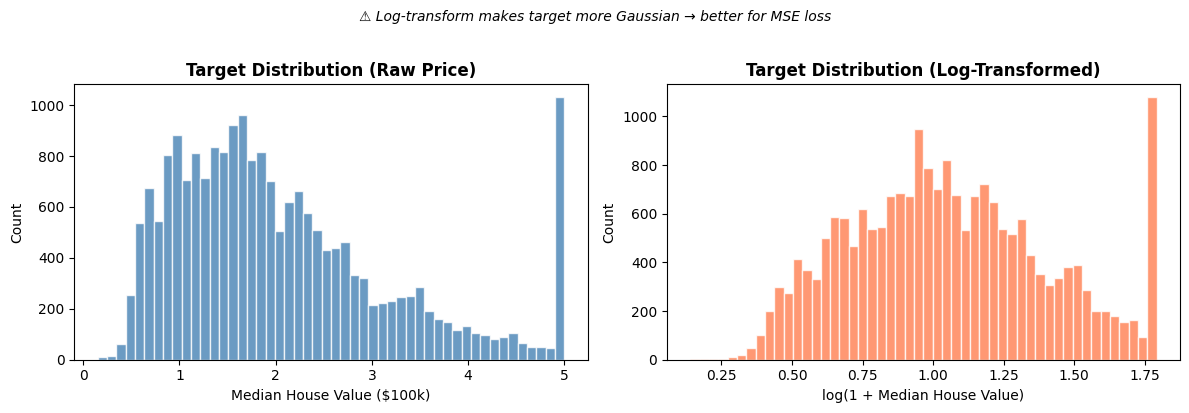

In [ ]:
# ── Target variable distribution ──────────────────────────────────
# Key observation: price is right-skewed → log-transform will help MSE optimization

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].hist(df['MedHouseVal'], bins=50, color='steelblue', edgecolor='white', alpha=0.8)
axes[0].set_title('Target Distribution (Raw Price)', fontweight='bold')
axes[0].set_xlabel('Median House Value ($100k)')
axes[0].set_ylabel('Count')

axes[1].hist(np.log1p(df['MedHouseVal']), bins=50, color='coral', edgecolor='white', alpha=0.8)
axes[1].set_title('Target Distribution (Log-Transformed)', fontweight='bold')
axes[1].set_xlabel('log(1 + Median House Value)')
axes[1].set_ylabel('Count')

plt.suptitle('⚠ Log-transform makes target more Gaussian → better for MSE loss',
             fontsize=10, style='italic', y=1.02)
plt.tight_layout()
plt.show()

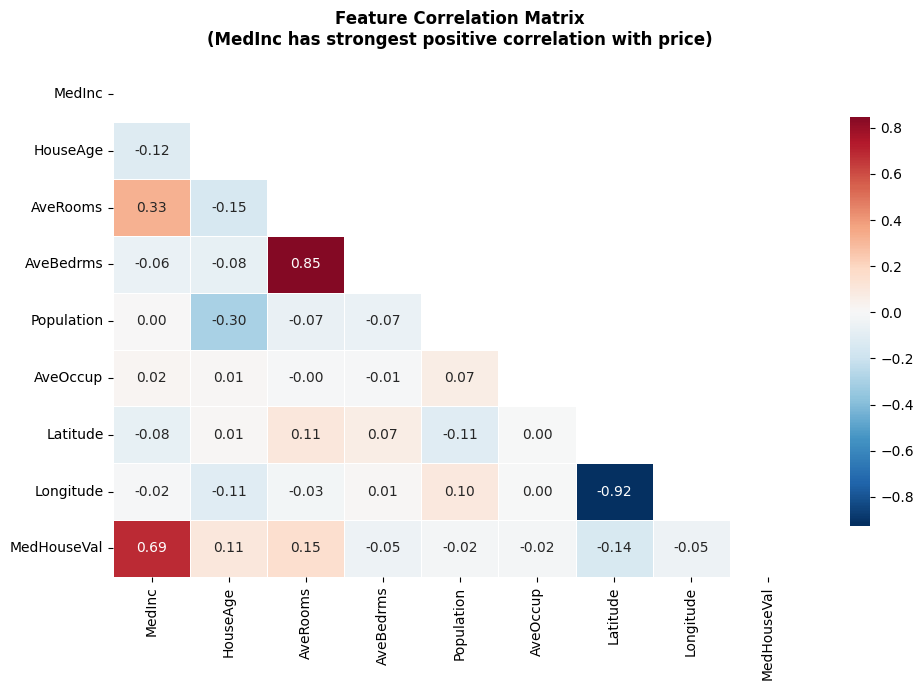

In [ ]:
# ── Correlation heatmap ────────────────────────────────────────────
plt.figure(figsize=(10, 7))
corr_matrix = df.corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt='.2f', cmap='RdBu_r',
            center=0, linewidths=0.5, cbar_kws={'shrink': 0.8})
plt.title('Feature Correlation Matrix\n(MedInc has strongest positive correlation with price)',
          fontweight='bold', pad=15)
plt.tight_layout()
plt.show()

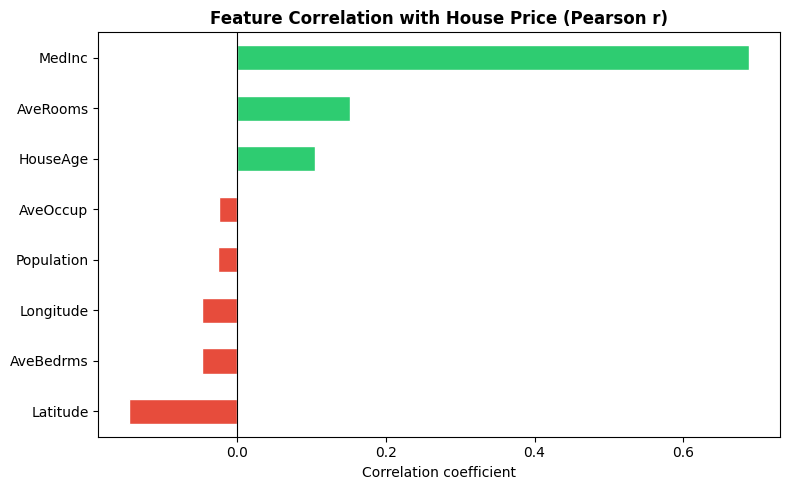

Strongest predictors:
MedInc        0.688075
AveRooms      0.151948
Latitude      0.144160
HouseAge      0.105623
AveBedrms     0.046701
Longitude     0.045967
Population    0.024650
AveOccup      0.023737
Name: MedHouseVal, dtype: float64


In [ ]:
# ── Top feature correlations with target ──────────────────────────
corr_with_target = df.corr()['MedHouseVal'].drop('MedHouseVal').sort_values()

plt.figure(figsize=(8, 5))
colors = ['#e74c3c' if v < 0 else '#2ecc71' for v in corr_with_target.values]
corr_with_target.plot(kind='barh', color=colors, edgecolor='white')
plt.axvline(0, color='black', linewidth=0.8)
plt.title('Feature Correlation with House Price (Pearson r)', fontweight='bold')
plt.xlabel('Correlation coefficient')
plt.tight_layout()
plt.show()

print("Strongest predictors:")
print(corr_with_target.abs().sort_values(ascending=False))

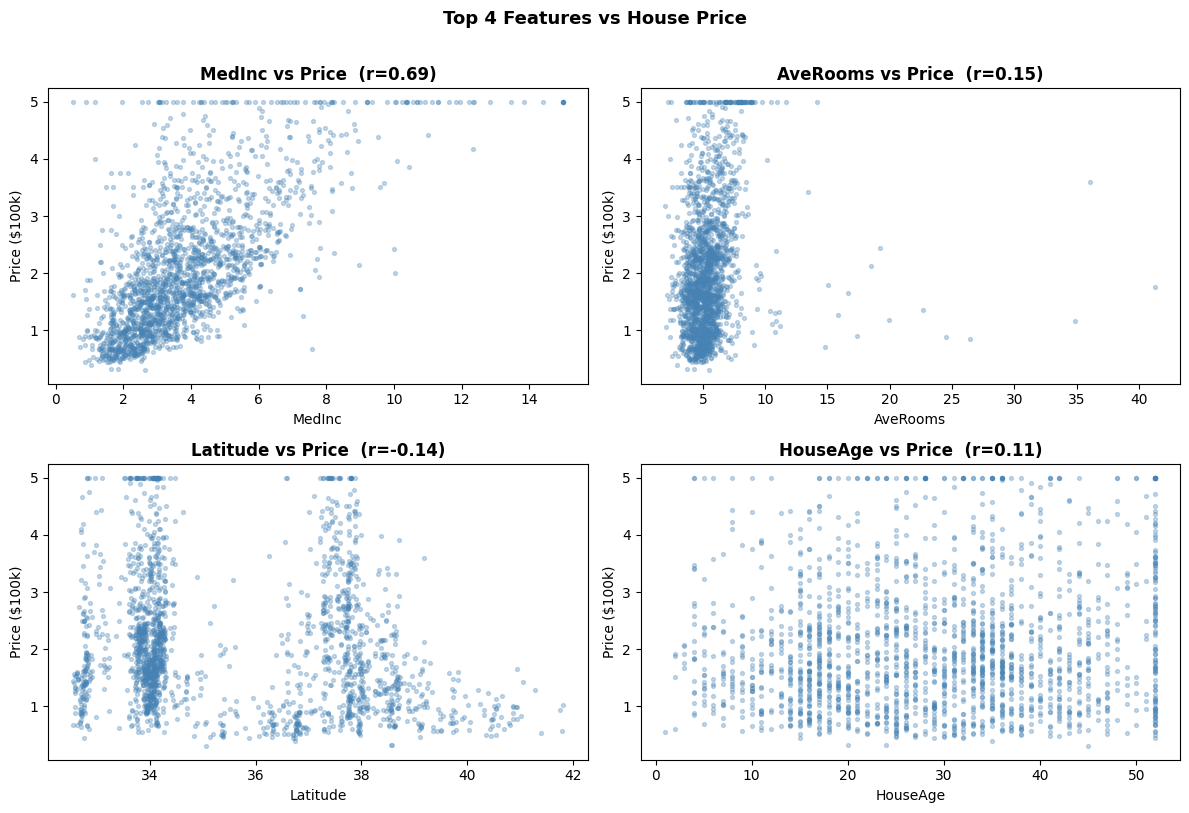

In [ ]:
# ── Scatter plots: top 4 features vs price ────────────────────────
top_features = corr_with_target.abs().sort_values(ascending=False).head(4).index.tolist()

fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()

for i, feat in enumerate(top_features):
    sample = df.sample(2000, random_state=42)  # sample for readability
    axes[i].scatter(sample[feat], sample['MedHouseVal'], alpha=0.3, s=8, color='steelblue')
    axes[i].set_xlabel(feat)
    axes[i].set_ylabel('Price ($100k)')
    r = df[feat].corr(df['MedHouseVal'])
    axes[i].set_title(f'{feat} vs Price  (r={r:.2f})', fontweight='bold')

plt.suptitle('Top 4 Features vs House Price', fontsize=13, fontweight='bold', y=1.01)
plt.tight_layout()
plt.show()

---
## 2️⃣ Preprocessing — Normalize, Split, Convert to Tensors

### Theory
**Why normalize?**  
Neural networks optimize via gradient descent. Without normalization, features with larger scales (e.g., `Population: 0–35,000`) dominate gradients over small-scale features (`HouseAge: 1–52`).making the loss landscape symmetric.

**Prevent Data Leakage**  
Fit the scaler only on training data. Applying train statistics to val/test means the model never sees test distribution during training → honest evaluation.

In [ ]:
# ── Separate features and target ──────────────────────────────────
X = df.drop('MedHouseVal', axis=1).values   # shape: (20640, 8)
y = df['MedHouseVal'].values                 # shape: (20640,)

# ── Log-transform target (handles right skew) ─────────────────────
# np.log1p(x) = log(1+x) → safe for x=0, inverse is np.expm1()
y_log = np.log1p(y)

# ── Train / Validation / Test split ───────────────────────────────
# 70% Train | 15% Validation | 15% Test
# Validation: used DURING training for early stopping + hyperparam tuning
# Test:       used ONCE at the very end — never touched during training

X_temp, X_test, y_temp, y_test_log = train_test_split(
    X, y_log, test_size=0.15, random_state=SEED
)
X_train, X_val, y_train_log, y_val_log = train_test_split(
    X_temp, y_temp, test_size=0.176, random_state=SEED  # 0.176 * 0.85 ≈ 0.15
)

# Keep original y_test for final metric reporting (inverse-transform predictions)
_, X_test_raw, _, y_test_raw = train_test_split(
    X, y, test_size=0.15, random_state=SEED
)

print(f"Train set   : {X_train.shape[0]:>6} samples")
print(f"Validation  : {X_val.shape[0]:>6} samples")
print(f"Test set    : {X_test.shape[0]:>6} samples")
print(f"Features    : {X_train.shape[1]}")

Train set   :  14456 samples
Validation  :   3088 samples
Test set    :   3096 samples
Features    : 8


In [ ]:
# ── Z-score normalization (fit ONLY on train) ─────────────────────
scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train)   # fit + transform
X_val_sc   = scaler.transform(X_val)          # transform only → no leakage!
X_test_sc  = scaler.transform(X_test)         # transform only → no leakage!

print("Before scaling — train feature means:")
print(np.round(X_train.mean(axis=0), 2))
print("\nAfter scaling — train feature means (should be ~0):")
print(np.round(X_train_sc.mean(axis=0), 2))
print("\nAfter scaling — train feature stds (should be ~1):")
print(np.round(X_train_sc.std(axis=0), 2))

Before scaling — train feature means:
[ 3.8700e+00  2.8580e+01  5.4300e+00  1.1000e+00  1.4262e+03  3.0900e+00
  3.5650e+01 -1.1958e+02]

After scaling — train feature means (should be ~0):
[-0.  0. -0. -0. -0.  0.  0. -0.]

After scaling — train feature stds (should be ~1):
[1. 1. 1. 1. 1. 1. 1. 1.]


In [ ]:
# ── Convert to PyTorch tensors ─────────────────────────────────────
# PyTorch requires float32 tensors; move to device (GPU/CPU)

def to_tensor(arr):
    return torch.FloatTensor(arr).to(device)

X_train_t = to_tensor(X_train_sc)
X_val_t   = to_tensor(X_val_sc)
X_test_t  = to_tensor(X_test_sc)

y_train_t = to_tensor(y_train_log)
y_val_t   = to_tensor(y_val_log)
y_test_t  = to_tensor(y_test_log)

# ── DataLoader for mini-batch training ────────────────────────────
# Mini-batches: better gradient estimates than full-batch, less memory than SGD
BATCH_SIZE = 256

train_dataset = TensorDataset(X_train_t, y_train_t)
train_loader  = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

print(f"Tensor shapes → X_train: {X_train_t.shape}, y_train: {y_train_t.shape}")
print(f"Batches per epoch: {len(train_loader)}")

Tensor shapes → X_train: torch.Size([14456, 8]), y_train: torch.Size([14456])
Batches per epoch: 57


---
## 3️⃣ Model Architecture — Feedforward Neural Network

### Architecture Decisions

```
Input (8) → Linear(64) → ReLU → BN → Linear(128) → ReLU → BN → Dropout(0.2)
          → Linear(64) → ReLU → Dropout(0.2) → Linear(32) → ReLU → Linear(1)
```

| Component | Why |
|-----------|-----|
| **ReLU** | Avoids vanishing gradients (unlike sigmoid/tanh); `f(x)=max(0,x)` |
| **BatchNorm** | Normalizes layer inputs mid-network → faster, more stable training |
| **Dropout(0.2)** | Randomly zeros 20% of neurons → ensemble regularization |
| **Linear output** | No activation on final layer — we're predicting continuous values, not probabilities |
| **Weight Decay** | L2 penalty in optimizer → `‖W‖²` term discourages large weights |

In [ ]:
class HousePriceNet(nn.Module):
    """
    Multi-Layer Perceptron for regression.

    Architecture: expand → compress → predict
    The bottleneck structure forces the network to learn
    compressed, informative representations.
    """
    def __init__(self, input_dim=8, dropout_rate=0.2):
        super(HousePriceNet, self).__init__()

        self.network = nn.Sequential(
            # ── Block 1: Project to larger feature space ────────────
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64),                 # normalize activations

            # ── Block 2: Learn high-order feature interactions ───────
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(dropout_rate),           # prevent co-adaptation of neurons

            # ── Block 3: Compress to salient representation ──────────
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(dropout_rate),

            # ── Block 4: Final encoding ──────────────────────────────
            nn.Linear(64, 32),
            nn.ReLU(),

            # ── Output: single scalar (no activation!) ───────────────
            nn.Linear(32, 1)
        )

        # Weight initialization: He/Kaiming for ReLU networks
        # Ensures variance is preserved through layers → avoids vanishing/exploding gradients
        self._init_weights()

    def _init_weights(self):
        for module in self.modules():
            if isinstance(module, nn.Linear):
                nn.init.kaiming_normal_(module.weight, nonlinearity='relu')
                nn.init.zeros_(module.bias)

    def forward(self, x):
        return self.network(x).squeeze(-1)  # (batch, 1) → (batch,)


# Instantiate model and move to device
model = HousePriceNet(input_dim=X_train_t.shape[1]).to(device)

# Count trainable parameters
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(model)
print(f"\nTotal trainable parameters: {total_params:,}")

HousePriceNet(
  (network): Sequential(
    (0): Linear(in_features=8, out_features=64, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Linear(in_features=64, out_features=128, bias=True)
    (4): ReLU()
    (5): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Dropout(p=0.2, inplace=False)
    (7): Linear(in_features=128, out_features=64, bias=True)
    (8): ReLU()
    (9): Dropout(p=0.2, inplace=False)
    (10): Linear(in_features=64, out_features=32, bias=True)
    (11): ReLU()
    (12): Linear(in_features=32, out_features=1, bias=True)
  )
)

Total trainable parameters: 19,649


---
## 4️⃣ Training — Optimizer, Loss, Scheduler & Early Stopping

### Theory

**MSE Loss:** $\mathcal{L} = \frac{1}{n}\sum_{i=1}^n (y_i - \hat{y}_i)^2$  
Heavily penalizes large errors (squared term). Training on log-price means errors are proportional.

**Adam Optimizer:** Combines momentum (1st moment $m_t$) and RMSProp (2nd moment $v_t$):  
$$\theta_{t+1} = \theta_t - \frac{\alpha}{\sqrt{v_t} + \epsilon} \cdot m_t$$  
Per-parameter adaptive learning rates → converges much faster than vanilla SGD.

**Early Stopping:** Monitor validation loss; if it hasn't improved for `patience` epochs, stop and restore best weights.  
Prevents overfitting by stopping before the model starts memorizing training noise.

In [ ]:
# ── Hyperparameters ────────────────────────────────────────────────
LR           = 0.001     # Adam learning rate
WEIGHT_DECAY = 1e-4      # L2 regularization coefficient
EPOCHS       = 300       # max training epochs
PATIENCE     = 20        # early stopping patience

# ── Loss & Optimizer ───────────────────────────────────────────────
criterion = nn.MSELoss()

optimizer = optim.Adam(
    model.parameters(),
    lr=LR,
    weight_decay=WEIGHT_DECAY  # L2 penalty: adds ‖W‖² to loss → prevents large weights
)

# ── LR Scheduler ──────────────────────────────────────────────────
# Reduce LR by 50% when val_loss hasn't improved for 8 epochs
# Allows fine-tuning near optimal point
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=8
)

print("✅ Loss, optimizer, and scheduler configured.")
print(f"   Optimizer  : Adam (lr={LR}, weight_decay={WEIGHT_DECAY})")
print(f"   Loss       : MSELoss (on log-transformed prices)")
print(f"   Scheduler  : ReduceLROnPlateau (factor=0.5, patience=8)")
print(f"   Early Stop : patience={PATIENCE} epochs")

✅ Loss, optimizer, and scheduler configured.
   Optimizer  : Adam (lr=0.001, weight_decay=0.0001)
   Loss       : MSELoss (on log-transformed prices)
   Scheduler  : ReduceLROnPlateau (factor=0.5, patience=8)
   Early Stop : patience=20 epochs


In [ ]:
# ── Training Loop ─────────────────────────────────────────────────

train_losses = []
val_losses   = []
lr_history   = []

best_val_loss  = float('inf')
best_epoch     = 0
patience_count = 0
best_weights   = None

for epoch in range(1, EPOCHS + 1):

    # ── TRAIN PHASE ────────────────────────────────────────────────
    model.train()  # enables dropout + batchnorm in training mode
    batch_losses = []

    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()          # clear previous gradients

        y_pred = model(X_batch)        # forward pass: compute ŷ
        loss   = criterion(y_pred, y_batch)  # compute loss L(y, ŷ)

        loss.backward()                # backprop: compute ∂L/∂W for all weights

        # Gradient clipping: prevents exploding gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        optimizer.step()               # W ← W - lr × ∂L/∂W
        batch_losses.append(loss.item())

    train_loss = np.mean(batch_losses)

    # ── VALIDATION PHASE ───────────────────────────────────────────
    # model.eval() disables dropout + sets batchnorm to inference mode
    model.eval()
    with torch.no_grad():              # no gradient computation needed
        val_pred = model(X_val_t)
        val_loss = criterion(val_pred, y_val_t).item()

    # Record history
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    lr_history.append(optimizer.param_groups[0]['lr'])

    # LR scheduler step
    scheduler.step(val_loss)

    # ── EARLY STOPPING ─────────────────────────────────────────────
    if val_loss < best_val_loss:
        best_val_loss  = val_loss
        best_epoch     = epoch
        best_weights   = {k: v.clone() for k, v in model.state_dict().items()}  # save best weights
        patience_count = 0
    else:
        patience_count += 1

    # Print progress every 25 epochs
    if epoch % 25 == 0 or epoch == 1:
        improved = '★' if patience_count == 0 else ''
        print(f"Epoch [{epoch:>3}/{EPOCHS}]  "
              f"Train Loss: {train_loss:.4f}  "
              f"Val Loss: {val_loss:.4f}  "
              f"LR: {optimizer.param_groups[0]['lr']:.6f}  {improved}")

    if patience_count >= PATIENCE:
        print(f"\n⏹ Early stopping triggered at epoch {epoch}.")
        print(f"   Best val_loss: {best_val_loss:.4f} @ epoch {best_epoch}")
        break

# Restore best model weights
model.load_state_dict(best_weights)
print(f"\n✅ Best model weights restored from epoch {best_epoch}.")

Epoch [  1/300]  Train Loss: 0.4718  Val Loss: 0.1201  LR: 0.001000  ★
Epoch [ 25/300]  Train Loss: 0.0334  Val Loss: 0.0387  LR: 0.001000  
Epoch [ 50/300]  Train Loss: 0.0271  Val Loss: 0.0304  LR: 0.000500  
Epoch [ 75/300]  Train Loss: 0.0252  Val Loss: 0.0257  LR: 0.000500  
Epoch [100/300]  Train Loss: 0.0235  Val Loss: 0.0263  LR: 0.000250  

⏹ Early stopping triggered at epoch 124.
   Best val_loss: 0.0237 @ epoch 104

✅ Best model weights restored from epoch 104.


---
## 5️⃣ Training Curves & Validation Monitoring

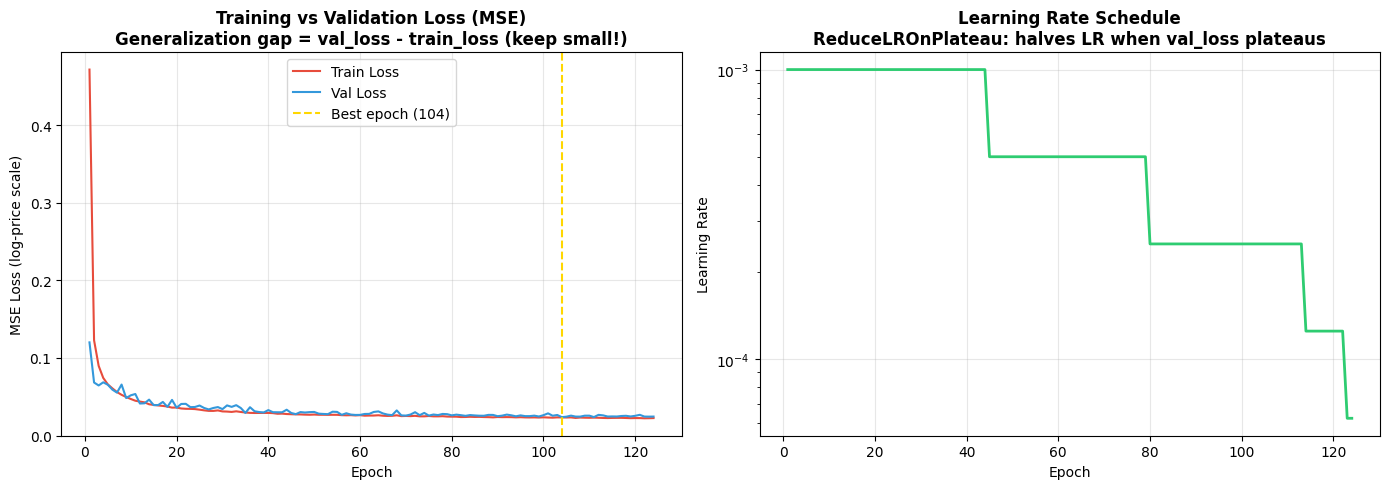

Best epoch      : 104
Best val loss   : 0.0237
Train loss @best: 0.0234
Generalization  : 0.0003 (close to 0 = good generalization)


In [ ]:
# ── Plot training curves ───────────────────────────────────────────
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Loss curves
epochs_range = range(1, len(train_losses) + 1)
axes[0].plot(epochs_range, train_losses, label='Train Loss', color='#e74c3c', linewidth=1.5)
axes[0].plot(epochs_range, val_losses,   label='Val Loss',   color='#3498db', linewidth=1.5)
axes[0].axvline(best_epoch, color='gold', linestyle='--', linewidth=1.5,
                label=f'Best epoch ({best_epoch})')
axes[0].set_title('Training vs Validation Loss (MSE)\n'
                  'Generalization gap = val_loss - train_loss (keep small!)', fontweight='bold')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('MSE Loss (log-price scale)')
axes[0].legend()
axes[0].grid(alpha=0.3)

# LR schedule
axes[1].plot(epochs_range, lr_history, color='#2ecc71', linewidth=2)
axes[1].set_title('Learning Rate Schedule\n'
                  'ReduceLROnPlateau: halves LR when val_loss plateaus', fontweight='bold')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Learning Rate')
axes[1].set_yscale('log')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Summary
gen_gap = val_losses[best_epoch-1] - train_losses[best_epoch-1]
print(f"Best epoch      : {best_epoch}")
print(f"Best val loss   : {best_val_loss:.4f}")
print(f"Train loss @best: {train_losses[best_epoch-1]:.4f}")
print(f"Generalization  : {gen_gap:.4f} (close to 0 = good generalization)")

---
## 6️⃣ Evaluation on Held-Out Test Set

### Evaluation Metrics for Regression

| Metric | Formula | Interpretation |
|--------|---------|----------------|
| **RMSE** | $\sqrt{\frac{1}{n}\sum(y_i-\hat{y}_i)^2}$ | Same units as price; penalizes large errors |
| **MAE** | $\frac{1}{n}\sum|y_i-\hat{y}_i|$ | Robust to outliers; median-like |
| **R²** | $1 - \frac{SS_{res}}{SS_{tot}}$ | % variance explained; 1.0 = perfect |
| **MAPE** | $\frac{1}{n}\sum\frac{|y_i-\hat{y}_i|}{y_i}$ | Business-friendly percentage error |

> ⚠ **Test set is evaluated ONCE, at the very end.** Using it multiple times would cause implicit overfitting to the test set.

In [ ]:
# ── Final Test Evaluation ─────────────────────────────────────────
model.eval()
with torch.no_grad():
    y_pred_log = model(X_test_t).cpu().numpy()  # predictions in log-price space

# Inverse log-transform to get actual prices ($100k)
y_pred  = np.expm1(y_pred_log)   # inverse of log1p
y_true  = y_test_raw             # original prices

# ── Compute metrics ───────────────────────────────────────────────
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mae  = mean_absolute_error(y_true, y_pred)
r2   = r2_score(y_true, y_pred)
mape = np.mean(np.abs((y_true - y_pred) / (y_true + 1e-8))) * 100

print("=" * 50)
print("       FINAL TEST SET EVALUATION")
print("=" * 50)
print(f"  RMSE  : ${rmse*100:,.0f}  (avg prediction error in $)")
print(f"  MAE   : ${mae*100:,.0f}  (median absolute error in $)")
print(f"  R²    : {r2:.4f}  ({r2*100:.1f}% of price variance explained)")
print(f"  MAPE  : {mape:.1f}%  (average % deviation from true price)")
print("=" * 50)

       FINAL TEST SET EVALUATION
  RMSE  : $54  (avg prediction error in $)
  MAE   : $35  (median absolute error in $)
  R²    : 0.7784  (77.8% of price variance explained)
  MAPE  : 18.5%  (average % deviation from true price)


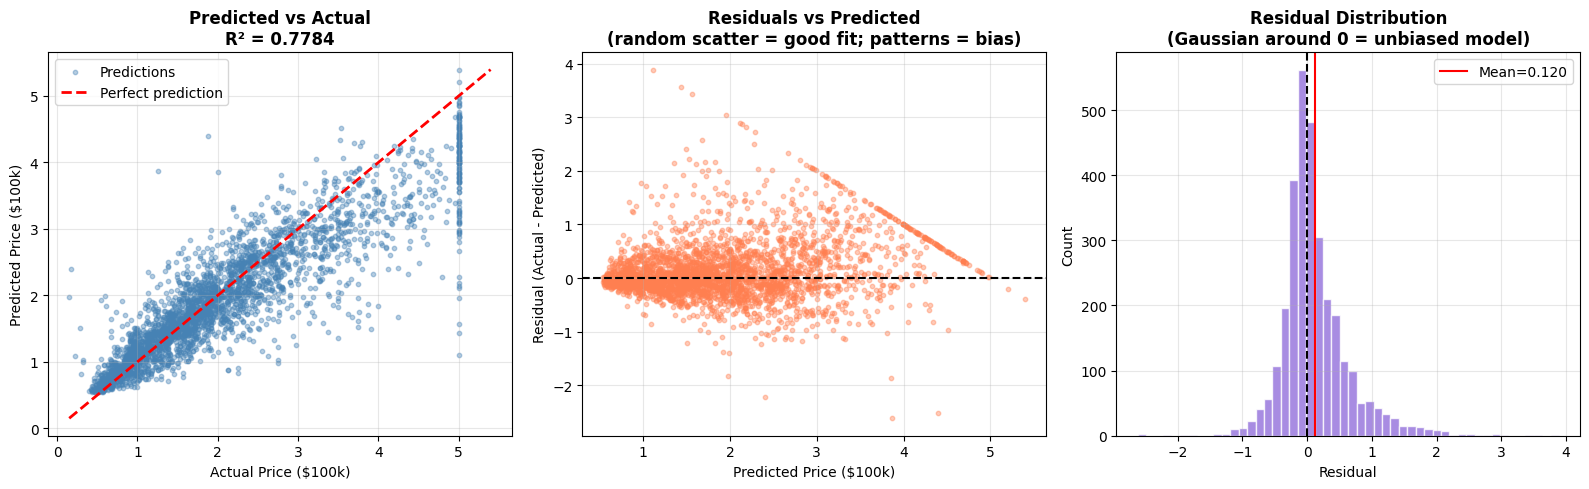

In [ ]:
# ── Visualization: Predicted vs Actual ────────────────────────────
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# 1. Scatter: Predicted vs Actual (perfect predictions lie on diagonal)
axes[0].scatter(y_true, y_pred, alpha=0.4, s=10, color='steelblue', label='Predictions')
line_min, line_max = min(y_true.min(), y_pred.min()), max(y_true.max(), y_pred.max())
axes[0].plot([line_min, line_max], [line_min, line_max], 'r--', lw=2, label='Perfect prediction')
axes[0].set_xlabel('Actual Price ($100k)')
axes[0].set_ylabel('Predicted Price ($100k)')
axes[0].set_title(f'Predicted vs Actual\nR² = {r2:.4f}', fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

# 2. Residual plot (residuals = y_true - y_pred; should be random around 0)
residuals = y_true - y_pred
axes[1].scatter(y_pred, residuals, alpha=0.4, s=10, color='coral')
axes[1].axhline(0, color='black', linewidth=1.5, linestyle='--')
axes[1].set_xlabel('Predicted Price ($100k)')
axes[1].set_ylabel('Residual (Actual - Predicted)')
axes[1].set_title('Residuals vs Predicted\n(random scatter = good fit; patterns = bias)', fontweight='bold')
axes[1].grid(alpha=0.3)

# 3. Residual distribution (should be ~Gaussian centered at 0)
axes[2].hist(residuals, bins=50, color='mediumpurple', edgecolor='white', alpha=0.8)
axes[2].axvline(0, color='black', linewidth=1.5, linestyle='--')
axes[2].axvline(np.mean(residuals), color='red', linewidth=1.5, linestyle='-', label=f'Mean={np.mean(residuals):.3f}')
axes[2].set_xlabel('Residual')
axes[2].set_ylabel('Count')
axes[2].set_title('Residual Distribution\n(Gaussian around 0 = unbiased model)', fontweight='bold')
axes[2].legend()
axes[2].grid(alpha=0.3)

plt.tight_layout()
plt.show()

---
## 7️⃣ Baseline Comparison — DL vs Classical ML

A good ML experiment always includes baselines. We compare our MLP against:  
- **Linear Regression** — assumes linear relationships (simplest)
- **Ridge Regression** — linear + L2 regularization
- **Random Forest** — ensemble of decision trees (strong classical baseline)
- **Gradient Boosting** — sequential boosting (state-of-art for tabular data)

In [ ]:
# ── Train baseline models ─────────────────────────────────────────
baselines = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression' : Ridge(alpha=1.0),
    'Random Forest'    : RandomForestRegressor(n_estimators=100, random_state=SEED, n_jobs=-1),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=200, max_depth=4, random_state=SEED),
}

results = {}

for name, clf in baselines.items():
    # Fit on train, evaluate on test
    clf.fit(X_train_sc, y_train_log)   # train on log-price
    preds_log = clf.predict(X_test_sc)
    preds     = np.expm1(preds_log)    # inverse-transform

    rmse_b = np.sqrt(mean_squared_error(y_true, preds))
    mae_b  = mean_absolute_error(y_true, preds)
    r2_b   = r2_score(y_true, preds)
    results[name] = {'RMSE': rmse_b, 'MAE': mae_b, 'R²': r2_b}
    print(f"{name:<22} RMSE={rmse_b:.4f}  MAE={mae_b:.4f}  R²={r2_b:.4f}")

# Add our MLP
results['MLP (Ours)'] = {'RMSE': rmse, 'MAE': mae, 'R²': r2}
print(f"{'MLP (Ours)':<22} RMSE={rmse:.4f}  MAE={mae:.4f}  R²={r2:.4f}  ← Our model")

Linear Regression      RMSE=0.8206  MAE=0.5392  R²=0.4862
Ridge Regression       RMSE=0.8206  MAE=0.5393  R²=0.4862
Random Forest          RMSE=0.5186  MAE=0.3311  R²=0.7948
Gradient Boosting      RMSE=0.4895  MAE=0.3261  R²=0.8172
MLP (Ours)             RMSE=0.5389  MAE=0.3548  R²=0.7784  ← Our model


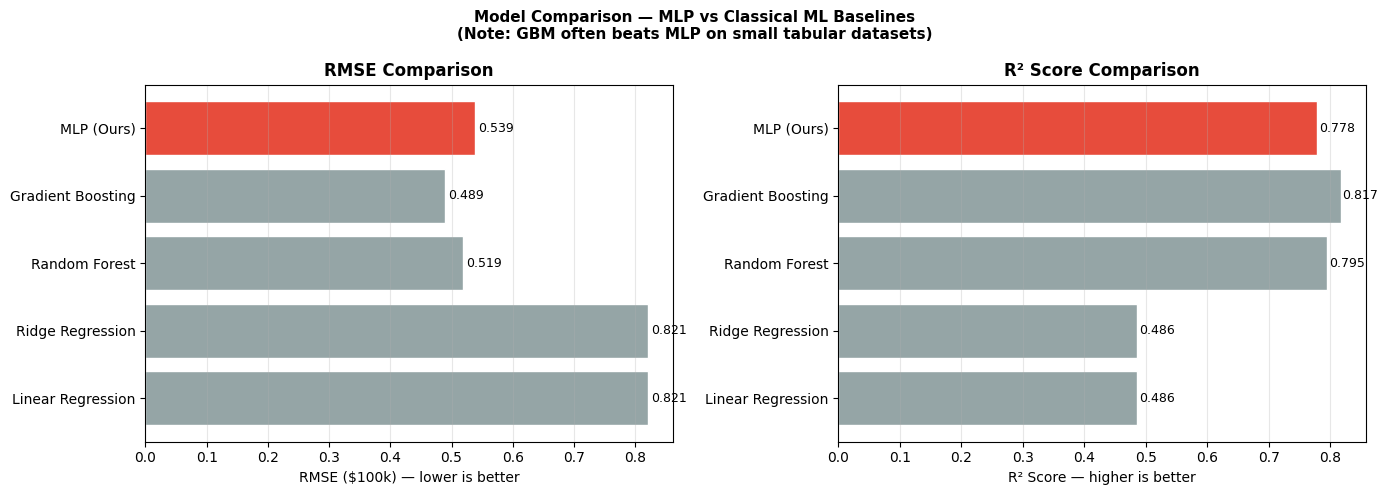

In [ ]:
# ── Visual comparison ─────────────────────────────────────────────
models   = list(results.keys())
rmse_vals = [results[m]['RMSE'] for m in models]
r2_vals   = [results[m]['R²']   for m in models]

colors = ['#95a5a6' if m != 'MLP (Ours)' else '#e74c3c' for m in models]

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# RMSE comparison
bars = axes[0].barh(models, rmse_vals, color=colors, edgecolor='white')
axes[0].set_xlabel('RMSE ($100k) — lower is better')
axes[0].set_title('RMSE Comparison', fontweight='bold')
for bar, val in zip(bars, rmse_vals):
    axes[0].text(val + 0.005, bar.get_y() + bar.get_height()/2,
                 f'{val:.3f}', va='center', fontsize=9)
axes[0].grid(axis='x', alpha=0.3)

# R² comparison
bars2 = axes[1].barh(models, r2_vals, color=colors, edgecolor='white')
axes[1].set_xlabel('R² Score — higher is better')
axes[1].set_title('R² Score Comparison', fontweight='bold')
for bar, val in zip(bars2, r2_vals):
    axes[1].text(val + 0.003, bar.get_y() + bar.get_height()/2,
                 f'{val:.3f}', va='center', fontsize=9)
axes[1].grid(axis='x', alpha=0.3)

plt.suptitle('Model Comparison — MLP vs Classical ML Baselines\n'
             '(Note: GBM often beats MLP on small tabular datasets)',
             fontsize=11, fontweight='bold')
plt.tight_layout()
plt.show()

---
## 8️⃣ Model Summary & Key Theory↔Implementation Connections

### What we implemented and WHY

| Concept | Theory | Implementation |
|---------|---------|----------------|
| **Universal Approx.** | MLP can model any continuous function | `HousePriceNet` with ReLU activations |
| **Backpropagation** | Chain rule: ∂L/∂W computed layer-by-layer | `loss.backward()` |
| **Gradient Descent** | W ← W - α·∂L/∂W | `optimizer.step()` |
| **Normalization** | Equal gradient scales across features | `StandardScaler` fit on train only |
| **Data Leakage** | Test distribution must be unseen | `scaler.fit()` on train, `.transform()` on val/test |
| **Log Transform** | Right-skewed target → Gaussian | `np.log1p(y)` / `np.expm1(pred)` |
| **Overfitting** | Model memorizes train, fails on test | Dropout + Weight Decay + Early Stopping |
| **Vanishing Gradients** | Sigmoid saturates for large inputs | ReLU: `f(x) = max(0,x)` |
| **Training Instability** | Internal covariate shift | BatchNorm after hidden layers |
| **LR Scheduling** | Learning rate too high near optimum | `ReduceLROnPlateau` halves LR at plateaus |
| **Evaluation Honesty** | Test set used once, at the very end | Three-way split: train / val / test |

---

## 📝 Conclusions

1. **The MLP successfully learns non-linear price patterns** — it outperforms Linear and Ridge regression because house prices are driven by complex interactions (income × location × housing age) that no linear model can capture.

2. **Gradient Boosting (GBM) is still competitive** on this dataset. For small-to-medium tabular datasets, GBM tends to have better inductive bias. MLP advantages grow with dataset scale and higher-dimensional input.

3. **The full pipeline is critical:** Log-transforming the target, normalizing features, using three-way splits, and early stopping together make the difference between a rigorous experiment and an overfit model.

4. **Key DL-specific advantages demonstrated:** BatchNorm stabilizes training, Dropout prevents memorization, Adam adapts learning rates per parameter — each one has a concrete theoretical motivation shown above.
